# Generalized information processing of temperature 

**Author**: M.G. Baltussen

**Estimated runtime**: 15 minutes 

**Generated output**: 
- `plots/sensor_temperature_infoproc_examples.svg` (manuscript fig. 3)
- `plots/sensor_temperature_infoproc.svg` (manuscript fig. 3)
- `plots/sensor_temperature_thermometer.svg` (manuscript fig. 3)

In [1]:
import pandas as pd
import numpy as np

import sklearn.preprocessing as preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import style
style.set_style()

from rich import print

In [3]:
def sigmoid_task(T, k=10, x0=0.5):
    return 1/(1 + np.exp(-k*(T-x0))).reshape(-1)

def pulse_task(T, k=10, x0=0.5):
    return 4*sigmoid_task(T, k, x0) * (1 - sigmoid_task(T, k, x0))

def binary_task(x, x0):
    return (x > x0).astype(int)

In [10]:
df_T = pd.read_csv("../data/RC_Temp_1.csv", index_col=0).drop(columns=['time', 'exp', 'pH'])
df_T2 = pd.read_csv("../data/RC_Temp_2.csv", index_col=0).drop(columns=['time', 'exp', 'pH'])
df_T3 = pd.read_csv("../data/RC_Temp_3.csv", index_col=0).drop(columns=['time', 'exp', 'pH', 'flow rate (uL/h)'])

df_all = pd.concat([df_T, df_T2, df_T3], ignore_index=True)

df_all = df_all.sort_values(by='T')

U = df_all[['T']].values
inputs = ['AVNIPFKVHLRCKAAFC'	,'SSVRWWSDDEWRW'	,'CCFSWRCRC'	,"CCF(pS)WRCRC"	,'IYPFVEPI'	,'TTMHPRL'	,'TKIFKI']
input_scaler = preprocessing.MinMaxScaler().fit(U)
U = input_scaler.transform(U)

X = df_all.drop(columns=['T', *inputs])
print(X.shape)

# Filter out non-resolvable features
features_idx = df_all.drop(columns=['T', *inputs]).std() > 1.0*df_all.drop(columns=inputs).groupby('T').std().mean()
X = X.loc[:, features_idx]
print(X.shape)

output_scaler = preprocessing.StandardScaler()
X = output_scaler.fit_transform(X)

N_u = X.shape[0]
N_k = X.shape[1]


(81, 103)

(81, 53)

In [11]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics

import itertools

In [12]:
def validate_smooth_task(task, reg, k):
    scores = []
    weights = []
    x0s = np.arange(30.75, 51, 1.5)
    x0s = input_scaler.transform(x0s.reshape(-1, 1))   

    bounds = np.diff(input_scaler.transform(np.array([30, 45]).reshape(-1, 1)).ravel())

    r2_scores = []
    for x0 in x0s:
        y_true = task(U, k=k, x0=x0)
        _scores = []
        _weights = []

        y_trues = []
        y_preds = []
        for idx_in, idx_out in model_selection.RepeatedKFold(n_splits=len(U)//5, n_repeats=100, random_state=42).split(X):
            reg.fit(X[idx_in], y_true[idx_in].ravel())

            range_of_interest_idx = ((x0 - bounds) < U[idx_out]) & (U[idx_out] < (x0 + bounds))
            idxs = idx_out[range_of_interest_idx.ravel()]
            if len(idxs) < 1:
                _scores.append(0)
                _weights.append(0)
                continue
            y_pred = reg.predict(X[idxs])

            score = ((y_true[idxs] - y_pred)**2).mean()
            y_trues.append(y_true[idxs])
            y_preds.append(y_pred)
            _scores.append(score)
            _weights.append(len(idxs))

        scores.append(_scores)
        weights.append(_weights)
        
        r2_scores.append(metrics.r2_score(np.array(list(itertools.chain(*y_trues))), np.array(list(itertools.chain(*y_preds)))))

    y_true = task(U, k=k, x0=0.5)
    y_preds = []
    u_preds = []
    for idx_in, idx_out in model_selection.KFold(n_splits=len(U)//5, shuffle=True, random_state=42).split(X):
        reg.fit(X[idx_in], y_true[idx_in].ravel())
        y_pred = reg.predict(X[idx_out])
        y_preds.append(y_pred)
        u_preds.append(U[idx_out])


    return np.sqrt(np.average(np.array(scores), axis=1, weights=np.array(weights))), r2_scores, y_preds, u_preds

def validate_classification_task(task, reg):
    scores = []
    weights = []
    x0s = np.arange(30.75, 51, 1.5)
    x0s = input_scaler.transform(x0s.reshape(-1, 1))
    for x0 in x0s:
        y_true = task(U, x0=x0)
        y_preds = []
        _scores = []
        _weights = []
        for idx_in, idx_out in model_selection.RepeatedStratifiedKFold(n_splits=len(U)//5, n_repeats=100, random_state=42).split(X, y_true):
            reg.fit(X[idx_in], y_true[idx_in].ravel())
            y_preds.append(reg.predict(X[idx_out]))
            score = metrics.matthews_corrcoef(y_true[idx_out], reg.predict(X[idx_out]))
            _scores.append(score)
            _weights.append(len(idx_out))

        scores.append(_scores)
        weights.append(_weights)

    y_true = task(U, x0=0.5)
    y_preds = []
    u_preds = []
    for idx_in, idx_out in model_selection.StratifiedKFold(n_splits=len(U)//5, shuffle=True, random_state=42).split(X, y_true):
        reg.fit(X[idx_in], y_true[idx_in].ravel())
        y_preds.append(reg.predict(X[idx_out]))
        u_preds.append(U[idx_out])


    return np.average(np.array(scores), axis=1, weights=np.array(weights)), y_preds, u_preds




In [13]:
sigmoid_nmse, sigmoid_r2_scores, sigmoid_example, sigmoid_example_x = validate_smooth_task(sigmoid_task, 
                                                                          linear_model.Ridge(alpha=1), k=12)
pulse_nmse, pulse_r2_scores, pulse_example, pulse_example_x = validate_smooth_task(pulse_task, 
                                                                    linear_model.Ridge(alpha=1), k=6)



In [ ]:
""" Some warnings may be raised for test-sets where one label only occurs one. This happens at some edge-case classifications"""
decision_scores, decision_example, decision_example_x = validate_classification_task(binary_task, svm.LinearSVC())

/home/mathieu/anaconda3/envs/enzymatic_sensor/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 15 members, which is less than n_splits=16.
  warnings.warn(
/home/mathieu/anaconda3/envs/enzymatic_sensor/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/mathieu/anaconda3/envs/enzymatic_sensor/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 15 members, which is less than n_splits=16.
  warnings.warn(
/home/mathieu/anaconda3/envs/enzymatic_sensor/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 15 members, which is less than n_splits=16.
  warnings.warn(
/home/mathieu/a

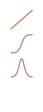

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(0.3, 1.2))

x = np.linspace(0, 1)

axes[0].plot(x, x, c='C1')
axes[1].plot(x, sigmoid_task(x, k=12, x0=0.5), c='C4')
axes[2].plot(x, pulse_task(x, k=12, x0=0.5), c='C4')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

plt.savefig("../plots/sensor_temperature_infoproc_examples.svg")

plt.show()

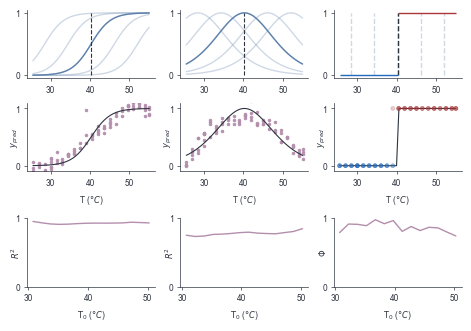

In [17]:
fig, axes = plt.subplots(3,3, figsize=(4.6, 3.2), constrained_layout=True)

cmap_bin = sns.color_palette("vlag", as_cmap=True, n_colors=2)

x = np.linspace(25.5, 55)
x = input_scaler.transform(x.reshape(-1, 1))

x0s = np.arange(30.75, 51, 1.5)
x0s = input_scaler.transform(x0s.reshape(-1, 1))

T_labels = np.array([30, 40, 50])
x_labels = input_scaler.transform(T_labels.reshape(-1, 1)).ravel()

for x0 in [0.1, 0.3, 0.5, 0.7, 0.9]:
    axes[0][0].plot(x, sigmoid_task(x, k=12, x0=x0), c='C0', alpha=0.3)
axes[0][0].plot(x, sigmoid_task(x, k=12, x0=0.5), c='C0')
axes[0][0].vlines(0.5, 0, 1, ls='dashed', color=style.nord_base.dark[0], lw=0.8)


for x0 in [0.1, 0.3, 0.5, 0.7, 0.9]:
    axes[0][1].plot(x, pulse_task(x, k=6, x0=x0), c='C0', alpha=0.3)
axes[0][1].plot(x, pulse_task(x, k=6, x0=0.5), c='C0')
axes[0][1].vlines(0.5, 0, 1, ls='dashed', color=style.nord_base.dark[0], lw=0.8)

axes[0][2].vlines([0.1, 0.3, 0.5, 0.7, 0.9], 0, 1, ls='dashed', color='C0', alpha=0.3)
axes[0][2].set_xticks(x_labels, T_labels)
axes[0][2].vlines(0.5, 0, 1, ls='dashed', color=style.nord_base.dark[0],  lw=1.0)
axes[0][2].hlines(0, 0, 0.5, color=cmap_bin(0), lw=1.0)
axes[0][2].hlines(1, 0.5, 1.0, color=cmap_bin(255), lw=1.0)

axes[2][0].plot(x0s, sigmoid_r2_scores, c='C4')
axes[2][1].plot(x0s, pulse_r2_scores, c='C4')
axes[2][2].plot(x0s, decision_scores, c='C4')

for x_pred, y_pred in zip(sigmoid_example_x, sigmoid_example):
    axes[1][0].scatter(x_pred, y_pred, s=4, c='C4')   
axes[1][0].plot(x, sigmoid_task(x, k=12, x0=0.5), c=style.nord_base.dark[0], lw=0.8)

for x_pred, y_pred in zip(pulse_example_x, pulse_example):
    axes[1][1].scatter(x_pred, y_pred, s=4, c='C4')  
axes[1][1].plot(x, pulse_task(x, k=6, x0=0.5), c=style.nord_base.dark[0], lw=0.8)

axes[1][2].plot(x, binary_task(x, x0=0.5), c=style.nord_base.dark[0], lw=0.8)
for x_pred, y_pred in zip(decision_example_x, decision_example):
    axes[1][2].scatter(x_pred, y_pred, s=8, c=y_pred, cmap=cmap_bin, zorder=2, alpha=0.25)  

axes[0][0].set_yticks([0, 1])
axes[0][1].set_yticks([0, 1])
axes[0][2].set_yticks([0, 1])

axes[1][0].set_yticks([0, 1])
axes[1][1].set_yticks([0, 1])
axes[1][2].set_yticks([0, 1])

axes[2][0].set_yticks([0, 1])
axes[2][1].set_yticks([0, 1])
axes[2][2].set_yticks([0, 1])

axes[0][0].set_xticks(x_labels, T_labels)
axes[0][1].set_xticks(x_labels, T_labels)
axes[0][2].set_xticks(x_labels, T_labels)

axes[1][0].set_xticks(x_labels, T_labels)
axes[1][1].set_xticks(x_labels, T_labels)
axes[1][2].set_xticks(x_labels, T_labels)

T0_labels = np.array([30, 40, 50])
x0_labels = input_scaler.transform(T0_labels.reshape(-1, 1)).ravel()
axes[2][0].set_xticks(x0_labels, T0_labels)
axes[2][1].set_xticks(x0_labels, T0_labels)
axes[2][2].set_xticks(x0_labels, T0_labels)


axes[1][0].set_ylim(-0.1, 1.1)
axes[1][1].set_ylim(-0.1, 1.1)
axes[1][2].set_ylim(-0.1, 1.1)

axes[1][0].set_xlabel(r"T ($\degree C$)")
axes[1][1].set_xlabel(r"T ($\degree C$)")
axes[1][2].set_xlabel(r"T ($\degree C$)")

axes[2][0].set_xlabel(r"$\text{T}_0$ ($\degree C$)")
axes[2][1].set_xlabel(r"$\text{T}_0$ ($\degree C$)")
axes[2][2].set_xlabel(r"$\text{T}_0$ ($\degree C$)")

axes[1][0].set_ylabel(r"$y_{pred}$", va='top')
axes[1][1].set_ylabel(r"$y_{pred}$", va='top')
axes[1][2].set_ylabel(r"$y_{pred}$", va='top')

axes[2][0].set_ylabel(r"$R^2$", va='top')
axes[2][1].set_ylabel(r"$R^2$", va='top')
axes[2][2].set_ylabel(r"$\Phi$", va='top')

plt.savefig("../plots/sensor_temperature_infoproc.svg")

plt.show()

In [18]:
y_true = U.ravel()
reg = linear_model.Ridge(alpha=0.1)

_scores = []
_weights = []
y_trues = []
y_preds = []
for idx_in, idx_out in model_selection.RepeatedKFold(n_splits=len(U)//5, n_repeats=100, random_state=42).split(X):
    reg.fit(X[idx_in], y_true[idx_in].ravel())
    y_pred = reg.predict(X[idx_out])
    score = np.sqrt(((input_scaler.inverse_transform(y_true[idx_out].reshape(-1, 1)) - input_scaler.inverse_transform(y_pred.reshape(-1, 1)))**2).mean())
    y_trues.append(y_true[idx_out])
    y_preds.append(y_pred)
    _scores.append(score)
    _weights.append(len(idx_out))

print(np.average(_scores, weights=_weights))
metrics.r2_score(np.array(list(itertools.chain(*y_trues))), np.array(list(itertools.chain(*y_preds))))

y_preds = []
y_trues = []
u_preds = []
for idx_in, idx_out in model_selection.KFold(n_splits=len(U)//5, shuffle=True, random_state=42).split(X):
    reg.fit(X[idx_in], y_true[idx_in].ravel())
    y_pred = reg.predict(X[idx_out])
    y_preds.append(y_pred)
    y_trues.append(y_true[idx_out])
    u_preds.append(U[idx_out])



1.3230066201825617

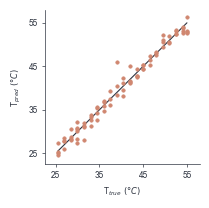

In [19]:
fig, ax = plt.subplots(figsize=(2,2))
ax.scatter(np.array(list(itertools.chain(*y_trues))), np.array(list(itertools.chain(*y_preds))), c='C1', s=6, zorder=10)
ax.plot(np.linspace(0,1), np.linspace(0,1), zorder=2, c=style.nord_base.dark[0], lw=0.8)

T_labels = np.array([25, 35, 45, 55])
x_labels = input_scaler.transform(T_labels.reshape(-1, 1)).ravel()

ax.set_xticks(x_labels, T_labels)
ax.set_yticks(x_labels, T_labels)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel(r"T$_{pred}~(\degree C)$")
ax.set_xlabel(r"T$_{true}~(\degree C)$")

plt.savefig("../plots/sensor_temperature_thermometer.svg")

plt.show()
